In [1]:
from agent import CircleAgent, SensorDQAgent
from datastructures import PERBuffer, Transition, DBuffer
from gridworld import GridWorld
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn as nn
from torch.nn.functional import mse_loss
from torch.optim import Adam
from random import random, choice, sample
from tqdm import tqdm

In [2]:
grid = [
        ['-', '-', '-', '-', '-'],
        ['-', 'w', '-', 'w', '-'],
        ['-', '-', '-', '-', '-'],
        ['-', 'w', '-', 'w', '-'],
        ['-', '-', '-', '-', '-'],
    ]
env = GridWorld((0,0), (4,4), grid)
user = CircleAgent(env,wait_time=5)

n_episodes = 100
episode_length = 128


Dynamic Weights in Multi-Objective Deep Reinforcement Learning
Table 2: Hyperparameters
General parameters (Minecart)
Exploration rate 1 → 0.05 over 100k steps
Buffer size 100.000
Frame skip 4
Discount factor 0.98
General parameters (DST)
Exploration rate 0.1 → 0.01 over 10k steps
Buffer size 10.000
Frame skip 1
Discount factor 0.95
Optimization parameters
Batch size 64 (Minecart), 16 (DST)
Optimizer SGD
Learning rate 0.02
Momentum 0.90
Nesterov Momentum true
N − 150
Prioritized sampling parameters
ε 0.01
α 2.0

In [3]:
def generate_training_data(env, agent, n_episodes, episode_length):
    data = []
    for i in range(n_episodes):
        trajectory = []
        for i in range(episode_length):
            action = agent.policy()
            newX = env.agent_location[0] + action[0]
            newY = env.agent_location[1] + action[1]
            trajectory.append((newX,newY))
            env.move_agent(newX, newY)
        data.append(trajectory)
    return data

user_paths = generate_training_data(env, user, n_episodes, episode_length)


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def simple_moving_average(data, window_size):
    if len(data) < window_size:
        raise ValueError("Data size must be greater than or equal to the window size.")
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def sum_next_n_values(data, n):
    return [sum(data[i:i+n]) for i in range(len(data)-n)]

def get_reward(vec, w):
    return w[0]*vec[0]+w[1]*vec[1]

def sample_and_update(replayBuffer, batch_size, gamma,  agent, target_network, w, rw):
    transitions = replayBuffer.sample(batch_size)
    s = transitions['obs']
    s_ = transitions['next_obs']

    q_values = agent.forward(s,w)
    next_q_values = target_network(s_,w)
    target_q_values = [get_reward(reward, w) + gamma * torch.max(next_q_values[i]) for i, reward in enumerate(transitions['reward'])]
    td_error = [mse_loss(q_values[i][action[1]], target_q_values[i]) for i, action in enumerate(transitions['action'])]

    rw_q_values = agent.forward(s,rw)
    rw_next_q_values = target_network(s_,rw)
    rw_target_q_values = [get_reward(reward, rw) + gamma * torch.max(rw_next_q_values[i]) for i, reward in enumerate(transitions['reward'])]
    rw_td_error = [mse_loss(rw_q_values[i][action[1]], rw_target_q_values[i]) for i, action in enumerate(transitions['action'])]
    return 0.5*(torch.stack(td_error).mean() + torch.stack(rw_td_error).mean() )


In [6]:
from agent import DuelingDQN
gamma = 0.99
epsilon = 0.1
learning_rate = 0.01
target_update_interval = 8
batch_size = 128
trajectory_length = 10

agent = DuelingDQN(trajectory_length)
target_network = DuelingDQN(trajectory_length)
target_network.load_state_dict(agent.state_dict())
optimizer = Adam(agent.parameters(), lr=learning_rate)
trajectory = deque(maxlen=trajectory_length*4)
replayBuffer = PERBuffer(batch_size*10, 0.7, 0.5)
diverseBuffer = DBuffer(batch_size*10)

#reward stuff
rewards = []


weights = set()

for path in tqdm(user_paths):
    visited = set()
    sensed = set()
    w = torch.tensor((np.random.uniform(0,1), np.random.uniform(0,1)))
    weights.add(w)
    episode_data = {
            'obs': torch.zeros((episode_length, 40), dtype=torch.float32),
            'action': torch.zeros((episode_length,2), dtype=torch.int32),
            'reward': torch.zeros((episode_length,2), dtype=torch.float32),
            'next_obs': torch.zeros((episode_length, 40), dtype=torch.float32),
        }
    ep_reward = 0

    #start traj is sensor off at unknown location
    for i in range(trajectory_length):
        trajectory.append(-1)
        trajectory.append(-1)
        trajectory.append(1)
        trajectory.append(0)

    for t,position in enumerate(path):
        visited.add(position)
        s = torch.tensor(trajectory).float()
        a = torch.tensor(agent.policy(s.unsqueeze(0),w)).int()
        r=0

        if a[1]: #give agent knowledge of position if sensor was activated
            trajectory.append(position[0])
            trajectory.append(position[1])
            sensed.add(position)
            r -= 1
        else:
            trajectory.append(-1)
            trajectory.append(-1)
        trajectory.append(a[0])
        trajectory.append(a[1])

        r = torch.tensor((len(sensed)/len(visited), r))
        ep_reward += get_reward(r, w)
        s_ = torch.tensor(trajectory).float().flatten()
        episode_data['obs'][t] = s
        episode_data['action'][t] = a
        episode_data['reward'][t] = r
        episode_data['next_obs'][t] = s_
        replayBuffer.add(s, a, r, s_)

        rw = weights.pop()
        weights.add(rw)

        optimizer.zero_grad()
        loss = sample_and_update(replayBuffer, batch_size, gamma, agent, target_network, w, rw)
        loss.backward()
        optimizer.step()
        if len(diverseBuffer.buffer)  > 0:
            optimizer.zero_grad()
            loss = sample_and_update(diverseBuffer, batch_size, gamma, agent, target_network, w, rw)
            loss.backward()
            optimizer.step()

        if t % target_update_interval:
            target_network.load_state_dict(agent.state_dict())
    diverseBuffer.push(episode_data, ep_reward)
    rewards.append(ep_reward/(w[0]*episode_length))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [56:33<00:00, 33.94s/it]


Text(0, 0.5, '% of max reward possible attained sma-5')

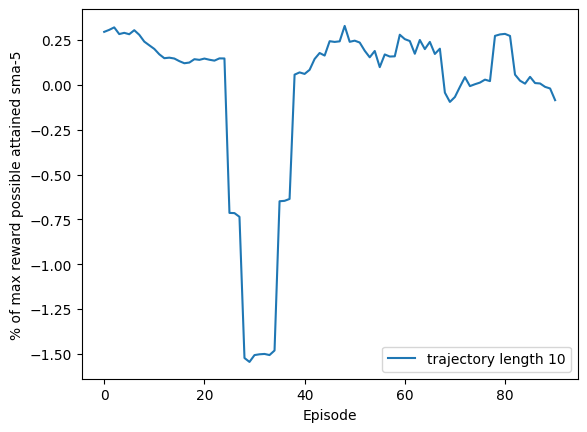

In [7]:

plt.plot(simple_moving_average(rewards,10), label='trajectory length {}'.format(trajectory_length))

plt.legend()
plt.xlabel('Episode')
plt.ylabel(f'% of max reward possible attained sma-5')

Text(0, 0.5, '% of max reward possible attained')

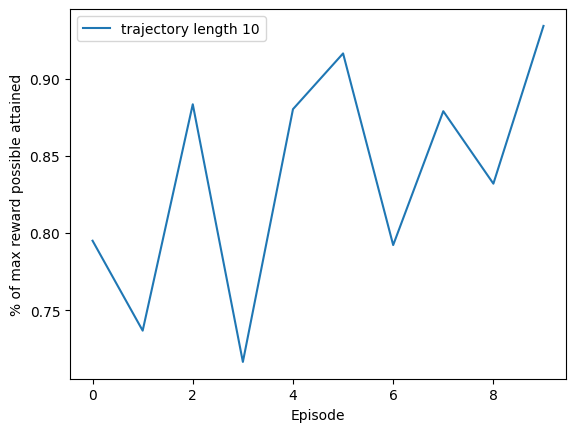

In [9]:
test_episodes = generate_training_data(env, user, n_episodes, episode_length)
test_rewards = []

for i in range(10):
    # linear combination of weights to create unknown weights for testing
    w1 = weights.pop()
    w2 = weights.pop()
    weights.add(w1)
    weights.add(w2)
    w = w1+w2

    visited = set()
    sensed = set()
    ep_reward = 0

    #start traj is sensor off at unknown location
    trajectory = deque(maxlen=trajectory_length*4)
    for i in range(trajectory_length):
        trajectory.append(-1)
        trajectory.append(-1)
        trajectory.append(1)
        trajectory.append(0)
    
    for pos in test_episodes[i]:
        visited.add(position)
        s = torch.tensor(trajectory).float()
        a = torch.tensor(agent.policy(s.unsqueeze(0),w)).int()
        r=0

        if a[1]: #give agent knowledge of position if sensor was activated
            trajectory.append(position[0])
            trajectory.append(position[1])
            sensed.add(position)
            r -= 1
        else:
            trajectory.append(-1)
            trajectory.append(-1)
        trajectory.append(a[0])
        trajectory.append(a[1])

        r = torch.tensor((len(sensed)/len(visited), r))
        ep_reward += get_reward(r, w)
        s_ = torch.tensor(trajectory).float().flatten()
    test_rewards.append(ep_reward/(w[0]*episode_length))


plt.plot(test_rewards, label='trajectory length {}'.format(trajectory_length))

plt.legend()
plt.xlabel('Episode')
plt.ylabel(f'% of max reward possible attained')
    